# Rolling-Unrolling LSTM Quickstart [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fpv-iplab/rulstm/blob/master/RULSTM/Rolling-Unrolling-LSTM-Quickstart.ipynb)
Antonino Furnari - antonino.furnari@unict.it - https://www.antoninofurnari.it/

## Introduction
This quickstart will guide you through a simplified training loop for the Rolling-Unrolling LSTM model. Please refer to the official repository for more information: https://github.com/fpv-iplab/rulstm and all options.


## Preliminaries

For this quickstart, we need to install the `lmdb` library, which allows to access the LMDB dataset containing our data.

Let's install our library with the following command:

In [ ]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.4 MB/s eta 0:00:00


## Cloning and inspecting the repository
We now need to clone the repository containing all the code which we are going to use:

In [ ]:
!git clone https://github.com/fpv-iplab/rulstm.git

Cloning into 'rulstm'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 208 (delta 51), reused 56 (delta 24), pack-reused 103
Receiving objects: 100% (208/208), 2.29 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (85/85), done.


Let's see what's inside the cloned repository:

In [ ]:
!ls -1 rulstm

FasterRCNN
FEATEXT
README.md
RULSTM


The codebase contains three main modules:
* **FasterRCNN**: weights and configuration file to run the object detector trained on EPIC-KITCHENS-55. We will not use the content of this module in this quickstart;
* **FEATEXT**: scripts to extract features from the RGB videos. We will not use the content of this module in this quickstart;
* **RULSTM**: the main module containing the Rolling-Unrolling LSTM code.

A README file is also included. This file contains additional information on how to train/validate/test the model and how to use different datasets. We will ignore this fine for this quickstart.

Let's move to the directory containing the main code:

In [ ]:
cd rulstm/RULSTM

/content/rulstm/RULSTM


Let's now inspect the content of the directory:

In [ ]:
!ls -1

data
dataset.py
environment.yml
main.py
models.py
requirements.txt
scripts
utils.py


We see four main Python files:
* `dataset.py` contains the classes resposible for loading the data;
* `main.py` provides a command line interface which allows to start the training/validation/testing of the models;
* `models.py` contains the implementation of the models;
* `utils.py` contains a set of utilities.

You can explore the code at the following link: https://github.dev/fpv-iplab/rulstm/tree/master/RULSTM


> **🙋‍♂️ Question 1**
>
> Have a look at the `main.py` file in the repository and answer the following questions:
>
> * Where is the training loop located?
> * Where is the model loaded?
> * Where does the logging happen?



The model we are going to use is based on LSTMs. You can find more information in the related papers: https://iplab.dmi.unict.it/rulstm/#paper

A diagram of the model is in the following:

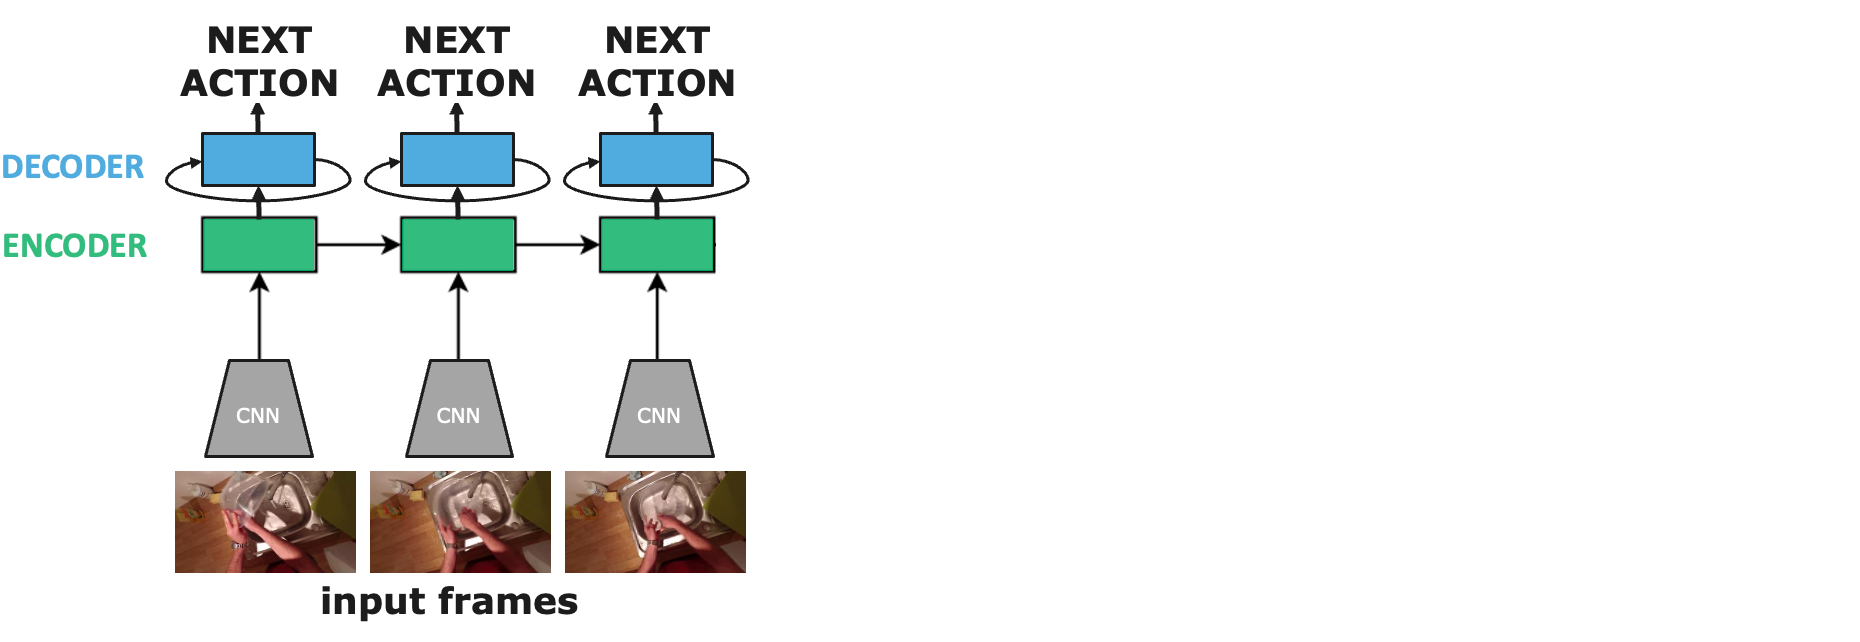

The implementation of the model can be found in `models.py`. For this quickstart, we will not delve into the detail of the model and we will instead use the command line interface provided by `main.py`.


> **🙋‍♂️ Question 2**
>
> Have a look at the `models.py` file in the repository and answer the following questions:
>
> * What's the purpose of the `OpenLSTM` class?
> * How does the forward pass of the `RULSTM` module changes if `sequence_completion` is set to `True`?



## Accessing the data

The model operates on features pre-extracted from the videos (obtained through the $\phi_m$ functions in the image above).
We will directly access pre-extracted features shared through google drive. For this quickstart, we will work only with the RGB modality and we will download the essential set of pre-extracted features. We will also use the older EPIC-KITCHENS-55 dataset rather than EPIC-KITCHENS-100 for compactness.

Please refer to the github repository for more details on the other available options: https://github.com/fpv-iplab/rulstm/tree/master

You first need to add the shared data to your google drive account. To do so, log into your google account (the same you are using with google colab), then click on the following link:

https://drive.google.com/drive/folders/1Ml8SM8TStyZngO9Yqi2RmqWSd60tgbaH

You will see something like this:

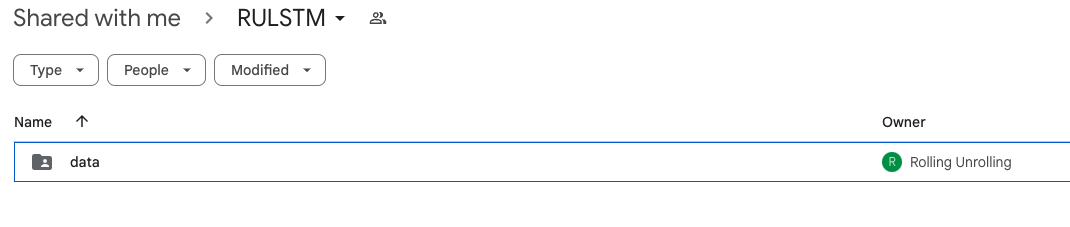

Click on the downward triangle next to "RULSTM" and then click on "Organize", then "Add Shortcut":

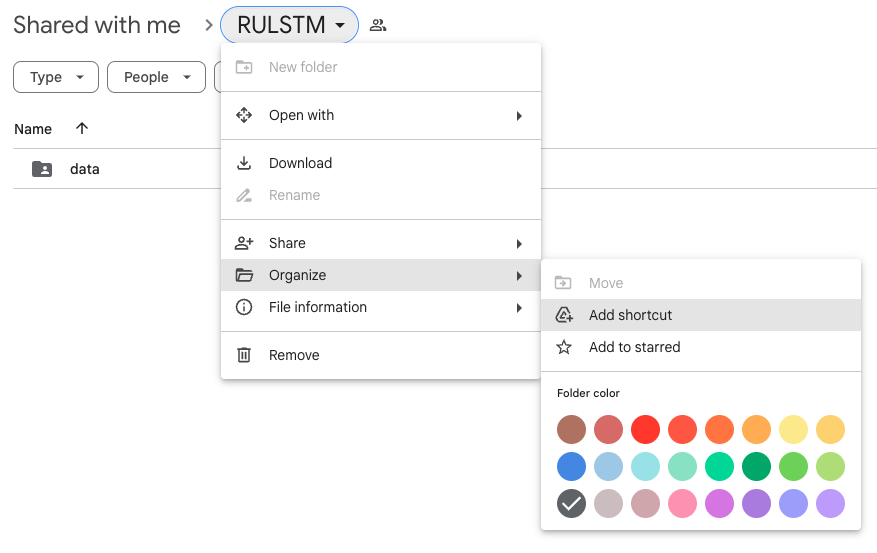

Select "All Locations", "My Drive", then "Add" in the bottom right corner:

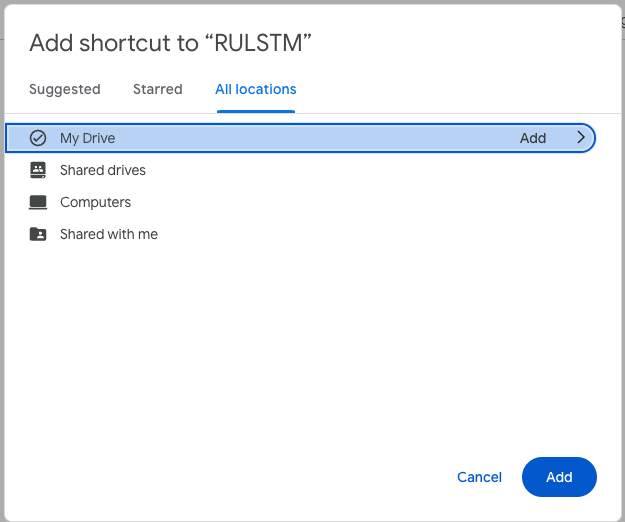

This will add a shortcut to your google drive, which we will use to access the files. Let's now mount the drive in this notebook (make sure to grant permissions when asked):

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


We should now find a file of about 6GB in the `/content/gdrive/MyDrive/RULSTM/data/ek55/rgb/` directory. Let's inspect it:

In [ ]:
!du -h /content/gdrive/MyDrive/RULSTM/data/ek55/rgb/data.mdb

6.1G	/content/gdrive/MyDrive/RULSTM/data/ek55/rgb/data.mdb


The file is an LMDB database which is used to store the features. You can find more information on LMDBs databases here: https://lmdb.readthedocs.io/en/release/ .

To make the file more easly accessible, let's create a symbolic link to our working directory:

In [ ]:
!mkdir -p data/ek55/rgb
!ln -s /content/gdrive/MyDrive/RULSTM/data/ek55/rgb/data.mdb data/ek55/rgb/data.mdb

#### Alternative approach
An alternative to mount the drive is to download the features from the authors' website. This approach will be slower in Colab, but it can be useful if this notebook is executed outside of Colab.

The features can be downloaded directly to the correct folder using the following code:

```
!mkdir -p data/ek55/rgb
!curl https://iplab.dmi.unict.it/sharing/rulstm/features/rgb/data.mdb -o data/ek55/rgb/data.mdb
```


> **🙋‍♂️ Question 3**
>
> Which function is used to load the representations from the lmdb file in the repository?
>
> **HINT**: use visual studio code's search function to locate the uses of the `lmdb` module.



## Training the model
The training procedure happens in two stages. A Sequence Completion Pretraining (SCP), and an anticipation finetuning, as described in the associated papers.

### Sequence Completion Pretraining
We will begin with the sequence completion pretraining stage, which is illustrated in the following (see the paper for more details):

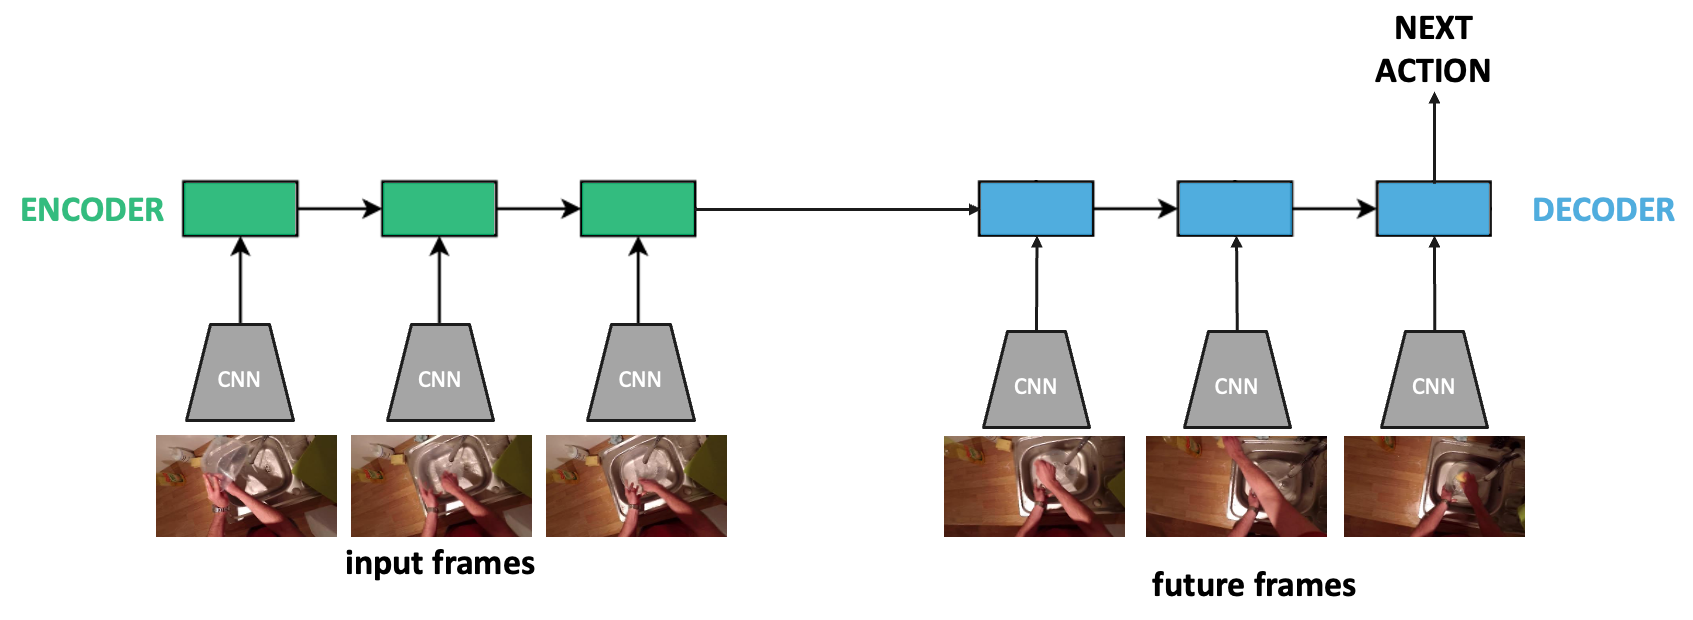

The following commands create the directory which will store the results and launch the training command:

In [ ]:
!mkdir -p models/ek55/
!python main.py train data/ek55 models/ek55 --modality rgb --task anticipation --sequence_completion --display_every 20 --epochs 5 --lr 0.5 --num_workers 2

Populating Dataset: 100% 23493/23493 [00:02<00:00, 8935.69it/s]
Populating Dataset: 100% 4979/4979 [00:01<00:00, 2545.56it/s]
[training] Epoch: 0.11. Loss: 7.12. Accuracy: 7.81% 
[training] Epoch: 0.22. Loss: 6.74. Accuracy: 12.40% 
[training] Epoch: 0.33. Loss: 6.54. Accuracy: 14.57% 
[training] Epoch: 0.43. Loss: 6.42. Accuracy: 15.93% 
[training] Epoch: 0.54. Loss: 6.34. Accuracy: 16.90% 
[training] Epoch: 0.65. Loss: 6.25. Accuracy: 18.04% 
[training] Epoch: 0.76. Loss: 6.18. Accuracy: 18.81% 
[training] Epoch: 0.87. Loss: 6.11. Accuracy: 19.62% 
[training] Epoch: 0.98. Loss: 6.06. Accuracy: 20.39% 
[training] Epoch: 1.00. Loss: 6.05. Accuracy: 20.45% 
[validation] Epoch: 1.00. Loss: 5.71. Accuracy: 26.51% [best: 26.51]%
[training] Epoch: 1.11. Loss: 5.51. Accuracy: 25.33% 
[training] Epoch: 1.22. Loss: 5.45. Accuracy: 26.35% 
[training] Epoch: 1.33. Loss: 5.44. Accuracy: 26.72% 
[training] Epoch: 1.43. Loss: 5.42. Accuracy: 27.07% 
[training] Epoch: 1.54. Loss: 5.42. Accuracy: 26.

To obtain a simplified pre-training, we added a few flags to the training command. Let's see all arguments in detail:
* `train` specifies that we want to perform the training procedure;
* `data/ek55 models/ek55` specifies where the models should be saved;
* `--modality rgb` specified that we want to use the RGB modality;
* `--task anticipation` specifies the kind of task we want to perform;
* `--sequence_completion` specifies that we want to perform the sequence-completion pretraining;
* `--display_every 20` specifies that we want to display the output every 100 interations;
* `--epochs 5` indicates that the model should be trained for $5$ epochs. This is a small number to increase speed for our simplified training procedure;
* `--lr 0.5` sets the learning rate to $0.5$. This is larger than the default $0.01$ for faster convergence;
* `--num_workers 2` indicates the number of workers to use for data loading. The default number is 4, but colab suggests a maximum of two workers.

All other parameters are left to their default values (see the code for more details).


> **🙋‍♂️ Question 4**
>
> Which other arguments/flags are available in `main.py`? List three of them.


The training procedure should take about 6 minutes. After the training procedure, we will find two models in the specified directory: the best model (the one with the highest validation accuracy) and the last one. Let's inspect the content of the directory:

In [ ]:
!ls models/ek55

RULSTM-anticipation_0.25_6_8_rgb_sequence_completion_best.pth.tar
RULSTM-anticipation_0.25_6_8_rgb_sequence_completion.pth.tar



> **🙋‍♂️ Question 5**
>
> Observe the training logs and answer the following questions:
> * Observe how the test accuracy has changed. Whould we expect to obtain much better results if training is carried out for more epochs (using the same hyperparameters)?
> * Do you think that changing the hyperparameters could lead to improvements? If so, how should they be changed?



### Anticipation fine-tuning
We will complete the training of the model with the anticipation fine-tuning procedure illustrated in the following (see paper for more details):

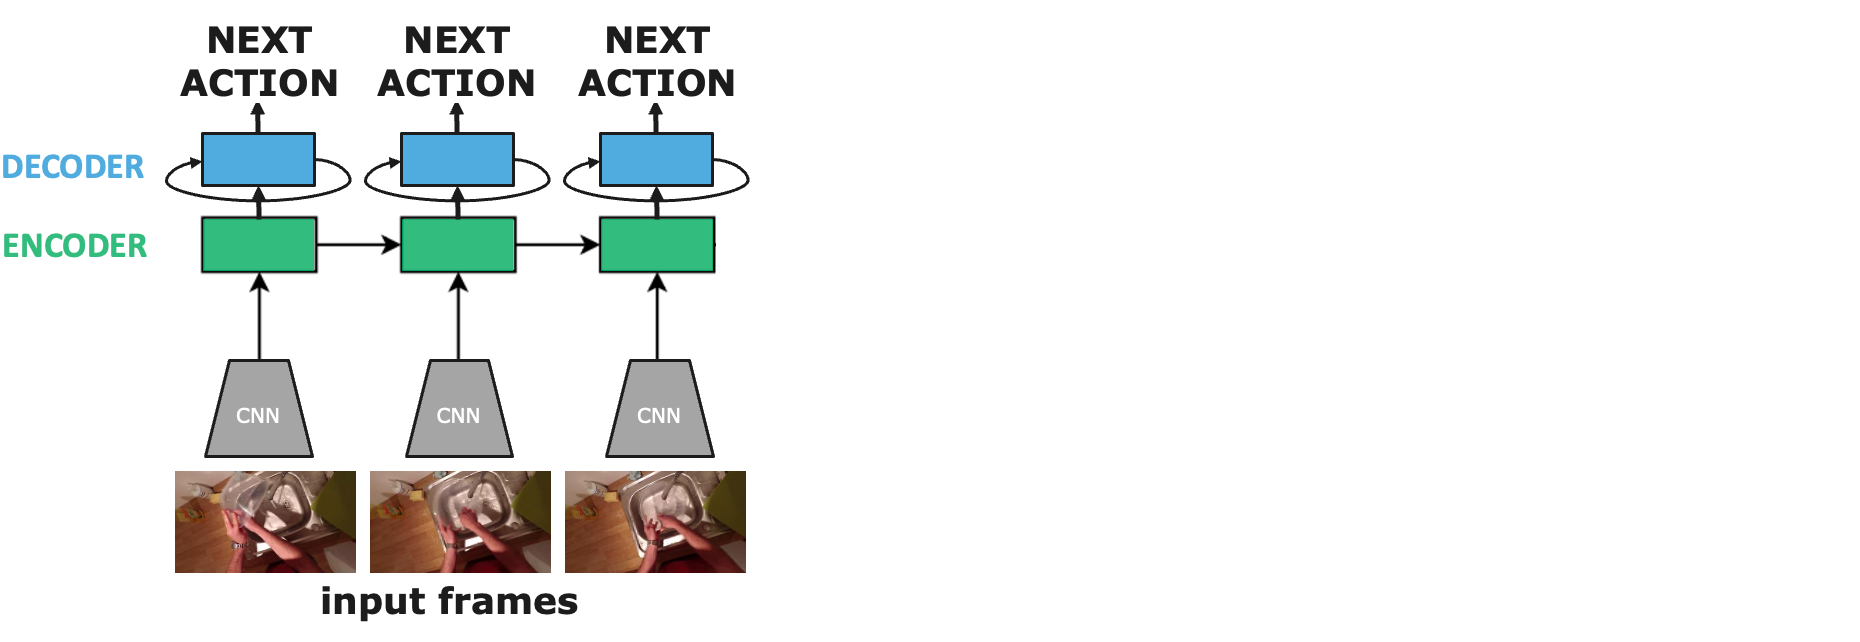

We can start the training with the following command:

In [ ]:
!python main.py train data/ek55 models/ek55 --modality rgb --task anticipation --display_every 20 --epochs 5 --lr 0.5 --num_workers 2

Populating Dataset: 100% 23493/23493 [00:02<00:00, 8277.14it/s]
Populating Dataset: 100% 4979/4979 [00:00<00:00, 8589.68it/s]
[training] Epoch: 0.11. Loss: 5.04. Accuracy: 30.47% 
[training] Epoch: 0.22. Loss: 5.04. Accuracy: 30.39% 
[training] Epoch: 0.33. Loss: 5.06. Accuracy: 29.64% 
[training] Epoch: 0.43. Loss: 5.06. Accuracy: 29.27% 
[training] Epoch: 0.54. Loss: 5.07. Accuracy: 29.09% 
[training] Epoch: 0.65. Loss: 5.09. Accuracy: 28.76% 
[training] Epoch: 0.76. Loss: 5.10. Accuracy: 28.68% 
[training] Epoch: 0.87. Loss: 5.09. Accuracy: 28.65% 
[training] Epoch: 0.98. Loss: 5.10. Accuracy: 28.63% 
[training] Epoch: 1.00. Loss: 5.10. Accuracy: 28.65% 
[validation] Epoch: 1.00. Loss: 5.75. Accuracy: 23.73% [best: 23.73]%
[training] Epoch: 1.11. Loss: 4.89. Accuracy: 30.69% 
[training] Epoch: 1.22. Loss: 4.92. Accuracy: 30.32% 
[training] Epoch: 1.33. Loss: 4.93. Accuracy: 30.11% 
[training] Epoch: 1.43. Loss: 4.91. Accuracy: 30.07% 
[training] Epoch: 1.54. Loss: 4.93. Accuracy: 29

The command is very similar to the previous one, but we removed the `--sequence_completion` flag to use the anticipation fine-tuning procedure. Note that, since the model will be initialized from the previously trained models, it's important to specify the same models directory.

At the end of the training procedure, we will find two addition models (best and last) in the specified directory:

In [ ]:
!ls models/ek55

RULSTM-anticipation_0.25_6_8_rgb_best.pth.tar
RULSTM-anticipation_0.25_6_8_rgb.pth.tar
RULSTM-anticipation_0.25_6_8_rgb_sequence_completion_best.pth.tar
RULSTM-anticipation_0.25_6_8_rgb_sequence_completion.pth.tar



> **🙋‍♂️ Question 6**
>
> Observe how the training and test accuracy evolve during the training procedure and answer the following questions:
> * Is there a gap between the two?
> * Is this gap constant throughout training?
> * What would we expect to see in 100 epochs?
> * What phenomenon is causing the gap?



## Validation

Now that the model is trained, we can check its performance on the validation set using the following command:

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None) # to show all columns in the table below

In [ ]:
!python main.py validate data/ek55 models/ek55 --modality rgb --task anticipation --num_workers 2

Loaded checkpoint for model <class 'models.RULSTM'>. Epoch: 1. Perf: 23.73.
Populating Dataset: 100% 4979/4979 [00:02<00:00, 1661.73it/s]
Evaluating...: 100% 39/39 [00:04<00:00,  9.33it/s]
                           2.0  1.75   1.5  1.25   1.0  0.75   0.5  0.25
Verb   Top-1 Accuracy    25.06 25.40 26.05 26.75 27.70 28.56 29.57 29.22
       Top-5 Accuracy    74.86 75.20 75.20 75.38 75.62 75.93 76.23 76.75
       Mean Top-5 Recall 26.34 27.11 27.89 27.95 28.07 29.05 29.33 30.71
Noun   Top-1 Accuracy    13.74 13.92 14.18 15.02 15.49 16.43 16.83 18.08
       Top-5 Accuracy    34.98 35.64 35.84 36.95 38.21 38.72 40.65 42.14
       Mean Top-5 Recall 26.90 27.74 27.88 28.53 30.09 30.11 31.94 33.37
Action Top-1 Accuracy    06.68 07.70 07.54 08.07 08.59 09.21 09.71 09.94
       Top-5 Accuracy    21.20 22.14 22.10 23.49 23.73 24.22 25.12 25.80
       Mean Top-5 Recall 04.53 04.72 04.89 05.17 05.30 05.37 05.45 06.04

Mean TtA(5): VERB: 1.54 NOUN: 0.88 ACTION: 0.57


Note that in this case, we provided the `validate` argument, rather than `train`. As a result, we obtain a table of scores (see paper for details).


> **🙋‍♂️ Question 7**
>
> Compare the results obtained with those reported in the paper (https://arxiv.org/pdf/2005.02190.pdf).
>
> Are the results different? Why?



## Test

The results above are computed on the validation set. It is not possible to compute test results as test labels are not public. To obtain test results, we should first save our predictions in the JSON format specified by the maintainers of the evaluation server (see https://codalab.lisn.upsaclay.fr/competitions/710#learn_the_details-submission-format):

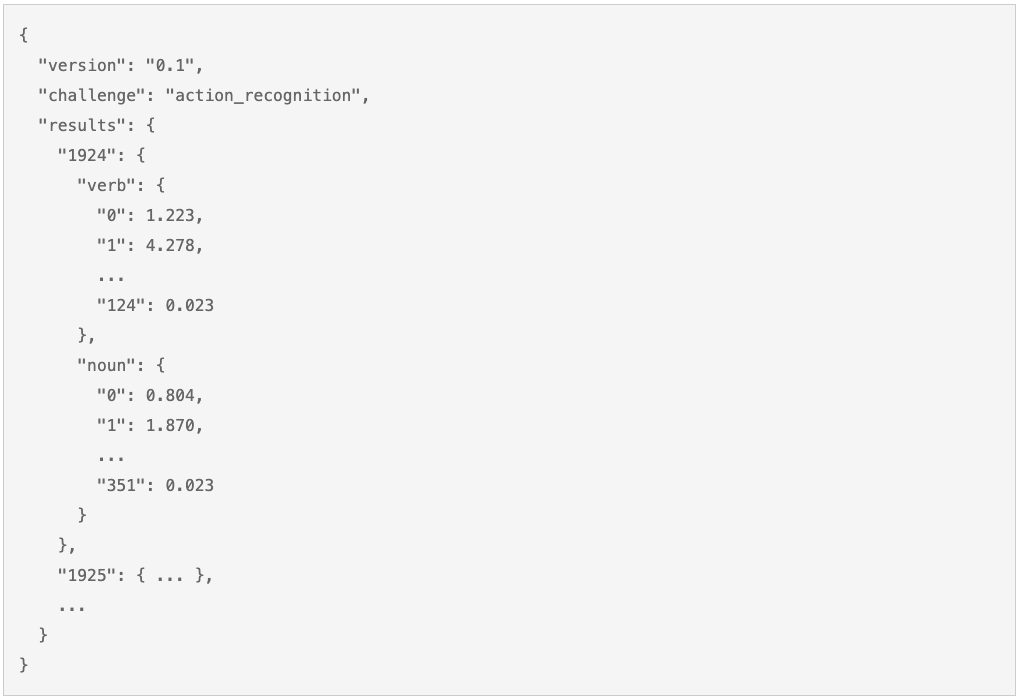

This can be done with the following commands:

In [ ]:
!mkdir -p jsons/ek55
!python main.py validate_json data/ek55 models/ek55 --modality rgb --task anticipation --json_directory jsons/ek55

Populating Dataset: 100% 4979/4979 [00:02<00:00, 1683.36it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loaded checkpoint for model <class 'models.RULSTM'>. Epoch: 1. Perf: 23.73.
Evaluating...: 100% 39/39 [00:04<00:00,  8.43it/s]


At the end of this process, we will find the evaluation json file in the `json/ek55` directory:

In [ ]:
!ls jsons/ek55

RULSTM-anticipation_0.25_6_8_rgb_validation.json


Let's have a look at the head of the JSON file to check if the format is correct:

In [ ]:
!head jsons/ek55/RULSTM-anticipation_0.25_6_8_rgb_validation.json

{
    "version": "0.1",
    "challenge": "action_anticipation",
    "results": {
        "1": {
            "verb": {
                "0": 0.25907620787620544,
                "1": 0.16191953420639038,
                "2": 0.1787872463464737,
                "3": 0.13653473556041718,


We may now follow the instructions of the evaluation server (https://codalab.lisn.upsaclay.fr/competitions/710) to upload our predictions and obtain test results. We'll skip this stage to avoid flooding the evaluation server.


> **🙋‍♂️ Question 8**
>
> Inspect the generated JSON through the Colab's file explorer.
>
> Is the formal really compliant?



## Conclusion

In this quickstart, we have seen only a simplified training loop for Rolling-Unrolling LSTM. If you want to know more and see how to use all modalities, modality fusion, and other dataset, head to the main repository: https://github.com/fpv-iplab/rulstm/tree/master